# LCA OWM in Montreal

# 1. Setup project

In [2]:
import brightway2 as bw
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
bw.projects.set_current('OWM LCA')

# 2. Database import (only have to do once or if you want to load an updated database)

Import ecoinvent

In [3]:
bw.import_ecoinvent_release('3.9.1', 'cutoff','ebenezer.kwofie@mcgill.ca', '2EBz*!#0DCH4')

NameError: name 'bw' is not defined

Import own data

In [13]:
#import OWM facilities database
imp = bw.ExcelImporter(r"C:\Users\smacdo55\Downloads\Jupyter Notebooks\Canada OWM Facilities Database.xlsx") # the path to your inventory excel file
imp.apply_strategies()
imp.match_database("ecoinvent-3.9.1-cutoff", fields=('name', 'unit', 'location', 'reference product')) # 'reference product'
imp.match_database(fields=('name', 'unit', 'location'))
imp.statistics()
imp.write_excel(only_unlinked=True)
list(imp.unlinked)
imp.write_database()

Extracted 3 worksheets in 0.11 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 9.38 seconds
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
15 datasets
147 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\smacdo55\AppData\Local\pylca\Brightway3\OWM-LCA.26f55f737af843ea9f9cc432ef022a9a\output\db-matching-OWM-Facilities-unlinked.xlsx


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 06/18/2025 15:58:45
  Finished: 06/18/2025 15:58:46
  Total time elapsed: 00:00:00
  CPU %: 25.20
  Memory %: 1.91
Created database: OWM Facilities


In [65]:
#import scenarios database
imp = bw.ExcelImporter(r"C:\Users\smacdo55\Downloads\Jupyter Notebooks\Scenarios Database.xlsx") # the path to your inventory excel file
imp.apply_strategies()
imp.match_database("OWM Facilities", fields=('name', 'unit', 'location', 'reference product')) # 'reference product'
imp.match_database(fields=('name', 'unit', 'location'))
imp.statistics()
imp.write_excel(only_unlinked=True)
list(imp.unlinked)
imp.write_database()

Extracted 1 worksheets in 0.05 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 8.90 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
3 datasets
26 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\smacdo55\AppData\Local\pylca\Brightway3\OWM-LCA.26f55f737af843ea9f9cc432ef022a9a\output\db-matching-Scenarios-unlinked.xlsx


0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 06/18/2025 16:20:26
  Finished: 06/18/2025 16:20:26
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 2.99
Created database: Scenarios


In [66]:
#check if it imported properly
list(bw.databases)

['ecoinvent-3.9.1-biosphere',
 'ecoinvent-3.9.1-cutoff',
 'OWM Facilities',
 'Scenarios']

In [63]:
# to delete a database
del bw.databases['Scenarios']

# 3. Set up scenarios

In [86]:
LCAdb =  bw.Database('Scenarios')
S1 = [a for a in LCAdb if 'S1' in a ['name']]
S2 = [a for a in LCAdb if 'S2' in a ['name']]
S3 = [a for a in LCAdb if 'S3' in a ['name']]
acts = S1[0], S2[0], S3[0]
acts

('S1' (tonne, CA-QC, None),
 'S2' (tonne, CA-QC, None),
 'S3' (tonne, CA-QC, None))

# 4. Choose an impact assessment method

In [68]:
CC_method = [m for m in bw.methods if 'IPCC 2021' in str(m) and not 'LT' in str(m) and 'GWP100' in str(m) and 'climate change' in str(m) and not 'biogenic' in str(m) and not 'fossil' in str(m) and not 'land use' in str(m) and not 'SLCFs' in str(m)]
CC_method

[('IPCC 2021', 'climate change', 'global warming potential (GWP100)')]

In [61]:
CC_method = [m for m in bw.methods if 'IPCC 2013' in str(m) and not 'LT' in str(m) and 'GWP100' in str(m) and 'climate change' in str(m) and not 'biogenic' in str(m) and not 'fossil' in str(m) and not 'land use' in str(m) and not 'SLCFs' in str(m)]
CC_method

[('IPCC 2013', 'climate change', 'global warming potential (GWP100)')]

# 5. Calculate LCA

5.1 MultiLCA

In [87]:
FU = [{x:1} for x in acts] #functional unit
bw.calculation_setups['OWM_Scenarios'] = {'inv':FU, 'ia': CC_method}
mylca = bw.MultiLCA('OWM_Scenarios')
mylca.results

array([[295.8599982 ],
       [307.83746162],
       [332.7019181 ]])

5.2 Single process LCA

In [ ]:
act = S1[0]


In [ ]:
lca = bw.LCA({act:1},CC_method)
lca.lci()
lca.lcia()
lca.score

1037.3276654999545

In [ ]:
{k:v for k,v in zip(CC_method, mylca.results)}

{('IPCC 2021',
  'climate change',
  'global warming potential (GWP100)'): array([1037.3276655])}

5.3 display results

In [88]:
mylcadf = pd.DataFrame(index = CC_method, columns = [(x['name']) for y in FU for x in y], data=mylca.results.T)
mylcadf

,S1,S2,S3
"(IPCC 2021, climate change, global warming potential (GWP100))",295.859998,307.837462,332.701918


optional

In [ ]:
mylcadf.to_excel('lcia_results.xlsx') # export to excel, e.g. for creating figures

In [ ]:
acts

('S1' (tonne, CA-QC, None),
 'S2' (tonne, CA-QC, None),
 'S3' (tonne, CA-QC, None))

In [ ]:
CC_method

[('IPCC 2021', 'climate change', 'global warming potential (GWP100)')]

In [89]:
#short names
labels_methods = {
    ('IPCC 2013', 'climate change', 'GWP 100a'): 'IPCC 2013',    
}
labels_act = {
    ('S1', 'CA-QC'):'S1',
    ('S2', 'CA-QC'):'S2',
    ('S3', 'CA-QC'):'S2',
}

In [90]:
#see updates labels
mylcadf

,S1,S2,S3
"(IPCC 2021, climate change, global warming potential (GWP100))",295.859998,307.837462,332.701918


In [91]:
df = mylcadf.rename(columns=labels_act, index=labels_methods)
df

,S1,S2,S3
"(IPCC 2021, climate change, global warming potential (GWP100))",295.859998,307.837462,332.701918


<Axes: xlabel='Impact category', ylabel='Impact score (kg CO2-eq)'>

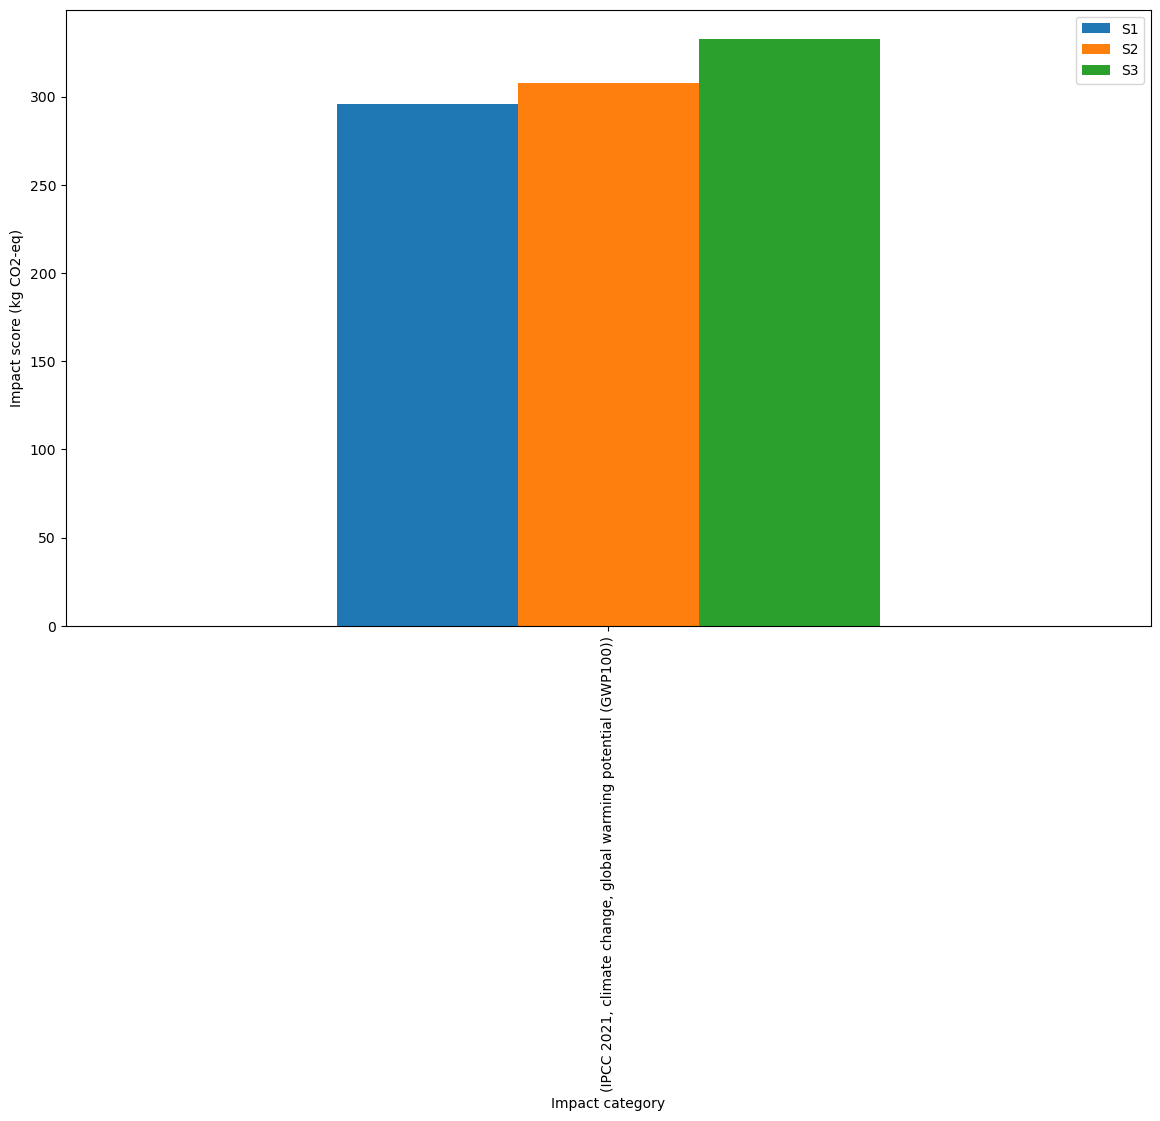

In [92]:
df.plot.bar(
    xlabel='Impact category',
    ylabel='Impact score (kg CO2-eq)',
    figsize=(14,8)
)

# 6. Contribution analysis

Adapted from: 
https://github.com/massimopizzol/advanced-lca-notebooks/blob/main/Specific-bw-tasks/Contribution-analysis-foreground-by-activity.ipynb

to do: how can I get it to show the activity name instead of key? has to do with act['code']

In [76]:
Facilities =  bw.Database('OWM Facilities')
windrow = [a for a in Facilities if 'Composter_terrebonne' in a ['name']]
Closed = [a for a in Facilities if 'Closed-tunnel Composter' in a ['name']]
AD = [a for a in Facilities if 'AD' in a ['name']]
landfill = [a for a in Facilities if 'Landfill_terrebonne' in a ['name']]
acts = windrow[0],Closed[0], AD[0],landfill[0]



In [93]:
# Forthe first activity in the list
act = bw.Database(acts[0]['database']).get(acts[0]['code'])
print(act)

'S1' (tonne, CA-QC, None)


In [94]:
functional_unit = {act: 1} 
mymethod = CC_method[0]
lca = bw.LCA(functional_unit, mymethod)
lca.lci()
lca.lcia()
print(lca.score)

295.8599981982356


In [95]:
def dolcacalc(act, mydemand, mymethod):
    my_fu = {act: mydemand} 
    lca = bw.LCA(my_fu, mymethod)
    lca.lci()
    lca.lcia()
    return lca.score

# For WtT
def getLCAresults(list_acts, mymethod):
    
    all_activities = []
    results = []
    for a in list_acts:
        act = bw.Database(a[0]).get(a[1])
        print(act)
        all_activities.append(act['name'])
        results.append(dolcacalc(act,1,mymethod)) # 1 stays for one unit of each process
        #print(act['name'])
     
    results_dict = dict(zip(all_activities, results))
    
    return results_dict

In [96]:
ca_dict = {}

for act in acts:
    
    exc_list = []
    contr_list = []

    for exc in list(act.exchanges()):
        
        if exc['type'] == 'biosphere':
            
            col = lca.activity_dict[exc['output']] # find column index of A matrix for the activity
            row = lca.biosphere_dict[exc['input']] # find row index of B matrix for the exchange
            contr_score = lca.biosphere_matrix[row,col] * lca.characterization_matrix[row,row]
            contr_list.append((exc['input'],exc['type'], exc['amount'], contr_score))
            
        elif exc['type'] == 'substitution':
            
            contr_score = dolcacalc(bw.Database(exc['input'][0]).get(exc['input'][1]), exc['amount'], mymethod)
            contr_list.append((exc['name'],exc['input'], exc['type'], exc['amount'], -contr_score))
            
        else:
            
            contr_score = dolcacalc(bw.Database(exc['input'][0]).get(exc['input'][1]), exc['amount'], mymethod)
            contr_list.append((exc['name'], exc['input'], exc['type'], exc['amount'], contr_score))
        
    ca_dict[act['name']] =  contr_list

In [97]:
getLCAresults(acts, mymethod)

'S1' (tonne, CA-QC, None)
'S2' (tonne, CA-QC, None)
'S3' (tonne, CA-QC, None)


{'S1': 295.8599981982356, 'S2': 307.83746162491605, 'S3': 332.7019180959074}

Check if sum of all exchanges equals the production impact

In [24]:
print(df.loc[df['type'] == 'production']['contribution'].sum())
print(df.loc[df['type'] != 'production']['contribution'].sum())

NameError: name 'df' is not defined

In [98]:
contribution_tables = {}  # Dictionary to store tables for each scenario

for act in acts:
    name = act['name']
    df = pd.DataFrame(ca_dict[name], columns=['name', 'input', 'type', 'amount', 'contribution'])

    # Calculate % contribution
    production_total = df.loc[df['type'] == 'production', 'contribution'].sum()
    df['%_contribution'] = 100 * df['contribution'] / production_total

    # Optional: sort by contribution or % if you want
    df = df.sort_values(by='contribution', ascending=False)

    # Save to dictionary
    contribution_tables[name] = df

    # Print or preview
    print(f"\n--- Contribution table for {name} ---")
    display(df.head(10))  # Show top 10 contributors (optional)


--- Contribution table for S1 ---


,name,input,type,amount,contribution,%_contribution
0,S1,"(Scenarios, 37030519024861417916dae7bfac124c)",production,1.000000,295.859998,100.000000
3,Landfill_saint_thomas,"(OWM Facilities, 0108f8e3577efb4d3a410a80c82be...",technosphere,0.248125,110.734796,37.428107
2,Landfill_terrebonne,"(OWM Facilities, 6e99a20c02ccf2d95d78403219c6e...",technosphere,0.208947,92.294923,31.195472
1,Landfill_saint sophie,"(OWM Facilities, f7a98f487bfc93c9a0ee9abc08a8c...",technosphere,0.124062,55.252651,18.675269
6,Landfill_cecile_de_milton,"(OWM Facilities, 3af7ac46474917a220a18cf30ce12...",technosphere,0.026118,12.972949,4.384827
4,Landfill_lachute,"(OWM Facilities, 09764f3bd90940ca1a5187a467a25...",technosphere,0.026118,12.949606,4.376937
5,Landfill_st-nicephore,"(OWM Facilities, 0ce66539a4829887ca499f796696f...",technosphere,0.019589,9.798926,3.312015
7,Composter_casselman,"(OWM Facilities, eeb262dba20ea97b736f102578f01...",technosphere,0.076349,1.210726,0.409223
10,Composter_saint thomas,"(OWM Facilities, 6f29bbf95a1b8057e9d45e90554d7...",technosphere,0.156168,0.684757,0.231446
9,Composter_terrebonne,"(OWM Facilities, dfc455135f96be2fc69fe163de47a...",technosphere,0.048586,-0.009127,-0.003085



--- Contribution table for S2 ---


,name,input,type,amount,contribution,%_contribution
0,S2,"(Scenarios, 37f84d7011f7b619bac6535fa43c3e69)",production,1.000000,307.837462,100.000000
3,Landfill_saint_thomas,"(OWM Facilities, 0108f8e3577efb4d3a410a80c82be...",technosphere,0.217653,97.135786,31.554245
1,Landfill_saint sophie,"(OWM Facilities, f7a98f487bfc93c9a0ee9abc08a8c...",technosphere,0.217653,96.934476,31.488850
2,Landfill_terrebonne,"(OWM Facilities, 6e99a20c02ccf2d95d78403219c6e...",technosphere,0.217653,96.140545,31.230944
8,Closed-tunnel Composter,"(OWM Facilities, 32d95f50c931647a3b464c2219355...",technosphere,0.166214,17.256637,5.605762
7,Composter_saint thomas,"(OWM Facilities, 6f29bbf95a1b8057e9d45e90554d7...",technosphere,0.056667,0.248469,0.080714
4,Composter_casselman,"(OWM Facilities, eeb262dba20ea97b736f102578f01...",technosphere,0.009973,0.158148,0.051374
6,Composter_terrebonne,"(OWM Facilities, dfc455135f96be2fc69fe163de47a...",technosphere,0.056667,-0.010646,-0.003458
5,Composter_complexe enviro st Michel,"(OWM Facilities, 52dbb59d7cef099d0fe5a7d558462...",technosphere,0.056667,-0.025957,-0.008432



--- Contribution table for S3 ---


,name,input,type,amount,contribution,%_contribution
0,S3,"(Scenarios, d823c3d3d2af4b9005f485ec7a9ca2ed)",production,1.000000,332.701918,100.000000
3,Landfill_saint_thomas,"(OWM Facilities, 0108f8e3577efb4d3a410a80c82be...",technosphere,0.217653,97.135786,29.196040
1,Landfill_saint sophie,"(OWM Facilities, f7a98f487bfc93c9a0ee9abc08a8c...",technosphere,0.217653,96.934476,29.135533
2,Landfill_terrebonne,"(OWM Facilities, 6e99a20c02ccf2d95d78403219c6e...",technosphere,0.217653,96.140545,28.896901
5,AD,"(OWM Facilities, 93fb132e1c36d33cf53e1ffec1165...",technosphere,0.199457,25.234470,7.584708
4,Closed-tunnel Composter,"(OWM Facilities, 32d95f50c931647a3b464c2219355...",technosphere,0.166214,17.256637,5.186816


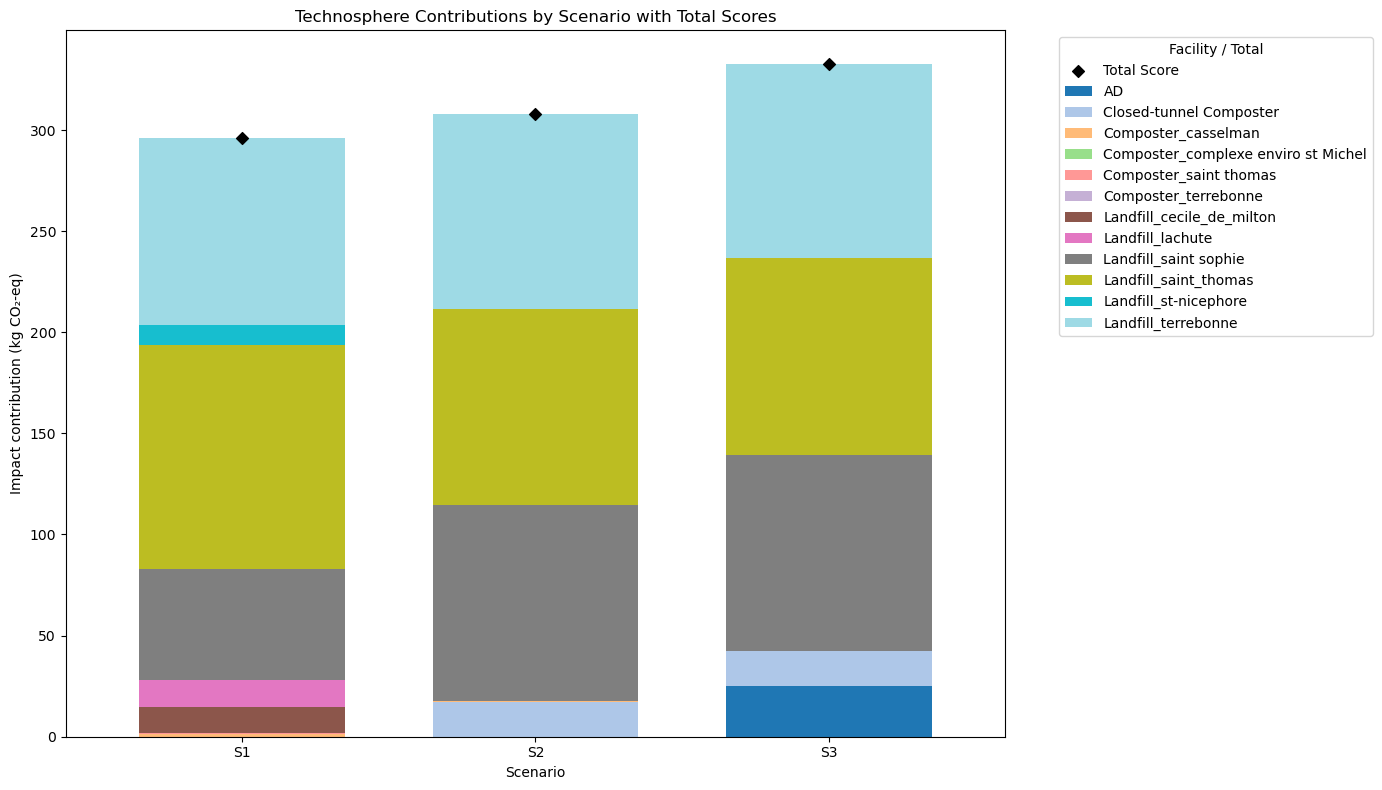

In [26]:
# Combine contribution data for all scenarios into one DataFrame
all_scenarios_df = []

for act in acts:
    scenario_name = act['name']
    df_temp = pd.DataFrame(ca_dict[scenario_name], columns=['name', 'input', 'type', 'amount', 'contribution'])
    df_temp = df_temp[df_temp['type'] == 'technosphere'].copy()
    df_temp['Scenario'] = scenario_name  # Add scenario label
    all_scenarios_df.append(df_temp)

# Combine into a single DataFrame
combined_df = pd.concat(all_scenarios_df, ignore_index=True)

# Pivot the table: index = Scenario, columns = facility/process names, values = contribution
pivot_df = combined_df.pivot_table(index='Scenario', columns='name', values='contribution', aggfunc='sum')
pivot_df = pivot_df.fillna(0)  # Replace NaN with 0s

# Step 1: Plot the stacked bar chart
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='tab20',
    width=0.7
)

# Step 2: Overlay diamond markers for total scores
# If you already have total scores in the same order as scenarios:
# Get scenario names from the pivot index
scenario_names = pivot_df.index.tolist()

# Get total impact scores from the MultiLCA object
total_scores = [mylca.results[i][0] for i in range(len(scenario_names))]  # assumes 1 method, 3 scenarios

# Plot diamonds on top of each bar
for i, score in enumerate(total_scores):
    ax.scatter(
        i,                     # x-position (bar index)
        score,                 # y-position (total impact score)
        marker='D',            # Diamond marker
        color='black',
        label='Total Score' if i == 0 else "",  # only label once for legend
        zorder=5
    )

# Step 3: Beautify the plot
plt.title('Technosphere Contributions by Scenario with Total Scores')
plt.xlabel('Scenario')
plt.ylabel('Impact contribution (kg CO₂-eq)')
plt.xticks(rotation=0)
plt.legend(title='Facility / Total', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Monte Carlo LCA

Adapted from:
https://github.com/massimopizzol/advanced-lca-notebooks/blob/main/Course-material/6-Comparative-Monte-Carlo.ipynb

this could also be helpful (from cmutel)
https://github.com/brightway-lca/brightway2/blob/master/notebooks/Monte%20Carlo%20from%20Excel%20import.ipynb

In [16]:
from bw2data.utils import uncertainify
from stats_arrays import NormalUncertainty
uncertain_db = bw.Database("OWM Facilities")
uncertain_db.write(
    uncertain_db.relabel_data(
        uncertainify(
            bw.Database("OWM Facilities").load(), 
            NormalUncertainty
        ), 
        "OWM Facilities" 
    )
)

Writing activities to SQLite3 database:
0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 06/03/2025 14:55:20
  Finished: 06/03/2025 14:55:20
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 3.07


In [17]:
db = bw.Database('OWM Facilities')
act_MC = [a for a in db if 'Landfill_terrebonne' in a ['name']][0]
act_MC

'Landfill_terrebonne' (tonne, CA-QC, None)

In [18]:
FU = {act_MC:1}
ipcc = ('IPCC 2013', 'climate change', 'global warming potential (GWP100)')
lca = bw.LCA(FU, ipcc)
lca.lci()
lca.lcia()
lca.score

489.86044833632894

In [19]:
mc = bw.MonteCarloLCA(FU, ipcc)
mc_results = [next(mc) for x in range(10)] # will take a bit of time, we are randomly sampling ecoinvent 100 times

489.86044833632894

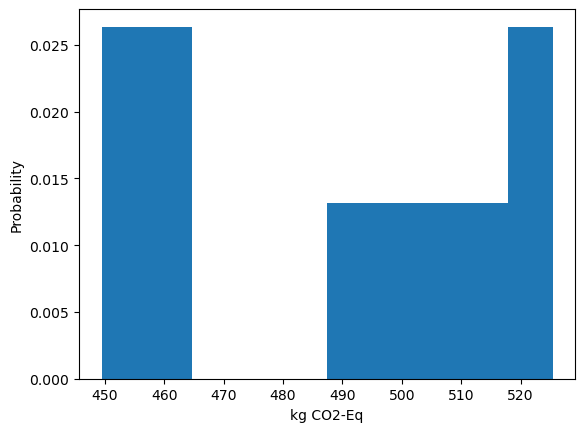

In [20]:
# plot MC results
plt.hist(mc_results, density=True)
plt.ylabel("Probability")
plt.xlabel(bw.methods[ipcc]["unit"])
pd.DataFrame(mc_results).describe() 
lca.score